## Def functions

In [1]:
def curl(gstep, vector):
    """
    vector = [Ax, Ay, Az]
    """
    
    Ax, Ay, Az = vector
    
    def dAdx(A):
        return np.gradient(A, axis = 0) / gstep[0]
    def dAdy(A):
        return np.gradient(A, axis = 1) / gstep[1]
    def dAdz(A):
        return np.gradient(A, axis = 2) / gstep[2]
    
    Cx = dAdy(Az) - dAdz(Ay)
    Cy = dAdz(Ax) - dAdx(Az)
    Cz = dAdx(Ay) - dAdy(Ax)
    
    return [Cx, Cy, Cz]

def dot_product(vector_1, vector_2):
    """
    vector = [Ax, Ay, Az]
    """
    
    Ax, Ay, Az = vector_1
    Bx, By, Bz = vector_2
    
    return Ax[:]*Bx[:] + Ay[:]*By[:] + Az[:]*Bz[:]

def cross_product(vector_1, vector_2):
    """
    vector = [Ax, Ay, Az]
    """
    
    Ax, Ay, Az = vector_1
    Bx, By, Bz = vector_2
    
    Cx = Ay * Bz - Az * Ay
    Cy = Az * Bx - Ax * Bz
    Cz = Ax * By - Ay * Bx
    
    return [Cx, Cy, Cz]
    

def norm(vector):
    """
    vector = [Ax, Ay, Az]
    """
    
    return np.sqrt(dot_product(vector, vector)[:])


## Import modules and functions

In [2]:
# # -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import glob
import re
from math import pi, sqrt, isclose

import pylab as pl
import matplotlib
from matplotlib.colors   import BoundaryNorm
from matplotlib.ticker   import MaxNLocator
from matplotlib.gridspec import GridSpec
from os import listdir

from matplotlib import rcParams


import import_ipynb
import Module_Diagnostics as MD
import netCDF4 as nc

from tempfile import mkdtemp
import os.path as path
import json

#import pdb
#pdb.set_trace()

importing Jupyter notebook from Module_Diagnostics.ipynb
testing compute_RMS(...):
This should be close to 1: 1.0285888730961674
This should be close to 0: 0.0


## Choose run and time for analysis

In [437]:
Cluster = 'Zoidberg'
Cluster = 'Curie'
Cluster = 'Occ'
# run_name = '20_05_18_event_only'
# time = 210
run_name = '21_07_06_event_only_uz_and_p3_without_cloud_dx=0.5'
time = 225
# # run_name = '26_07_06_event_only_uz_and_p3_without_cloud_dx=0.4'
# run_name = '26_07_06_event_only_uz_and_p3_without_cloud_dx=0.25'
# time = 125
# run_name = '27_07_06_event_only_uz_and_p3_without_cloud_dx=0.2'
# run_name = '30_07_06_Ohm_dx=0.25_V=1200'
run_name ='03_08_06_Ohm_dx=1_beta=0.1'
run_name = '02_08_06_Ohm_dx=0.5_beta=0.1'
run_name = '30_07_06_Ohm_dx=0.25_beta=0.1'
run_name = "02_08_06_Ohm_dx=0.20_beta=0.1"
run_name = "02_08_06_Ohm_dx=0.25_beta=0.1_V=850"
run_name = "02_08_06_Ohm_dx=0.25_beta=0.05"
time = 80


time = '%05d' % time    # Change the time to string format, needed by functions

filepath = '../' + Cluster + '/' + run_name + '/ncfiles/'
date = re.search('w_(.+?)_t', glob.glob(filepath+'Magw*_t'+time+'.nc')[0]).group(1)

print(date)

filepath_out = filepath+'../Images/'

03_08_21


## Get data in Magw, Hsw and Elew 

#### Clear local tmp folder

In [438]:
!rm -rf /tmp/*

rm: impossible de supprimer '/tmp/adcli-krb5-APwjvB': Opération non permise
rm: impossible de supprimer '/tmp/adcli-krb5-rJOzxV': Opération non permise
rm: impossible de supprimer '/tmp/adcli-krb5-wszFDB': Opération non permise
rm: impossible de supprimer '/tmp/systemd-private-7bf9bf2101f24d9f96ba7a1f2d9fc0bd-bluetooth.service-jvkfzh': Opération non permise
rm: impossible de supprimer '/tmp/systemd-private-7bf9bf2101f24d9f96ba7a1f2d9fc0bd-chronyd.service-rxVoDi': Opération non permise
rm: impossible de supprimer '/tmp/systemd-private-7bf9bf2101f24d9f96ba7a1f2d9fc0bd-colord.service-lUtKeh': Opération non permise
rm: impossible de supprimer '/tmp/systemd-private-7bf9bf2101f24d9f96ba7a1f2d9fc0bd-dbus-broker.service-cLqfig': Opération non permise
rm: impossible de supprimer '/tmp/systemd-private-7bf9bf2101f24d9f96ba7a1f2d9fc0bd-earlyoom.service-82FEaf': Opération non permise
rm: impossible de supprimer '/tmp/systemd-private-7bf9bf2101f24d9f96ba7a1f2d9fc0bd-ModemManager.service-ladHwh': Opé

### Download B, n, E, T, V

In [439]:
## Load B and X, Y, Z

# There might be some MemoryError. In that case, follow the guide:
# https://stackoverflow.com/questions/60563936/memoryerror-unable-to-allocate-3-78-gib-for-an-array-with-shape-802-842-1502
Magw = MD.import_data_3D(filepath, date, time, 'Magw')

x = Magw['x'].data
y = Magw['y'].data
z = Magw['z'].data

cwp = Magw['c_omegapi']
gstep = Magw['gstep']

nx,  ny,  nz  = len(x), len(y), len(z)
# Location of the planet is defined in the .ncfiles as (x,y,z) = (0,0,0)
nx0, ny0, nz0 = int(np.where(x==0)[0]), int(np.where(abs(y)==np.min(abs(y)))[0]), int(np.where(z==0)[0])
            
# Use memmap to alleviate RAM
# This stores big arrays on the disk, but in a way that still allows for most
# operations available on an np.array
file_Bx = path.join(mkdtemp(), 'Bx.dat')            
Bx = np.memmap(file_Bx, dtype='float32', mode='w+', shape=(nx,ny,nz))
Bx[:] = Magw['Bx']
file_By = path.join(mkdtemp(), 'By.dat')            
By = np.memmap(file_By, dtype='float32', mode='w+', shape=(nx,ny,nz))
By[:] = Magw['By']
file_Bz = path.join(mkdtemp(), 'Bz.dat')            
Bz = np.memmap(file_Bz, dtype='float32', mode='w+', shape=(nx,ny,nz))
Bz[:] = Magw['Bz']
del Magw
B = [Bx, By, Bz]

## Load N, Vxyz, and T
Hsw = MD.import_data_3D(filepath, date, time, 'Hsw')
# Density in nb/cm^3
file_N = path.join(mkdtemp(), 'N.dat')            
N = np.memmap(file_N, dtype='float32', mode='w+', shape=(nx,ny,nz))
N[:] = Hsw['n']
# Velocity in km/s
file_Vx = path.join(mkdtemp(), 'Vx.dat')            
Vx = np.memmap(file_Vx, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vx[:] = Hsw['Vx']
file_Vy = path.join(mkdtemp(), 'Vy.dat')            
Vy = np.memmap(file_Vy, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vy[:] = Hsw['Vy']
file_Vz = path.join(mkdtemp(), 'Vz.dat')            
Vz = np.memmap(file_Vz, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vz[:] = Hsw['Vz']
# Temperature in eV
file_T = path.join(mkdtemp(), 'T.dat')            
T = np.memmap(file_T, dtype='float32', mode='w+', shape=(nx,ny,nz))
T[:] = Hsw['T']
del Hsw
V = [Vx, Vy, Vz]

## Load E
# Electric field in mV/m
Elew = MD.import_data_3D(filepath, date, time, 'Elew')
file_Ex = path.join(mkdtemp(), 'Ex.dat')            
Ex = np.memmap(file_Ex, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ex[:] = Elew['Ex']*1e6
file_Ey = path.join(mkdtemp(), 'Ey.dat')            
Ey = np.memmap(file_Ey, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ey[:] = Elew['Ey']*1e6
file_Ez = path.join(mkdtemp(), 'Ez.dat')            
Ez = np.memmap(file_Ez, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ez[:] = Elew['Ez']*1e6
del Elew
E = [Ex, Ey, Ez]

Importing Magw 3D from ../Occ/02_08_06_Ohm_dx=0.25_beta=0.05/ncfiles/
Reading Bx...
Reading By...
Reading Bz...
Close file and return...
Importing Hsw 3D from ../Occ/02_08_06_Ohm_dx=0.25_beta=0.05/ncfiles/
Reading density...
Reading Ux...
Reading Uy...
Reading Uz...
Reading T...
Close file and return...
Importing Elew 3D from ../Occ/02_08_06_Ohm_dx=0.25_beta=0.05/ncfiles/
Reading Ex...
Reading Ey...
Reading Ez...
Close file and return...


In [440]:
file_Jx = path.join(mkdtemp(), 'Jx.dat')            
Jx = np.memmap(file_Jx, dtype='float32', mode='w+', shape=(nx,ny,nz))
Jx[:] = MD.Jx(B)
file_Jy = path.join(mkdtemp(), 'Jy.dat')            
Jy = np.memmap(file_Jy, dtype='float32', mode='w+', shape=(nx,ny,nz))
Jy[:] = MD.Jy(B)
file_Jz = path.join(mkdtemp(), 'Jz.dat')            
Jz = np.memmap(file_Jz, dtype='float32', mode='w+', shape=(nx,ny,nz))
Jz[:] = MD.Jz(B)

J = [Jx, Jy, Jz]

## Physics constants & Normalisation

In [441]:
qe = 1.60217662e-19 #C

In [442]:
b = 1e-9
j = 1e-9
v = 1e3
e = 1e3
n = 1e6

## Plot parametering

In [443]:
# %matplotlib notebook

## Playground

In [444]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### General view in the style of Moissard et al. 2019

<Figure size 792x792 with 0 Axes>

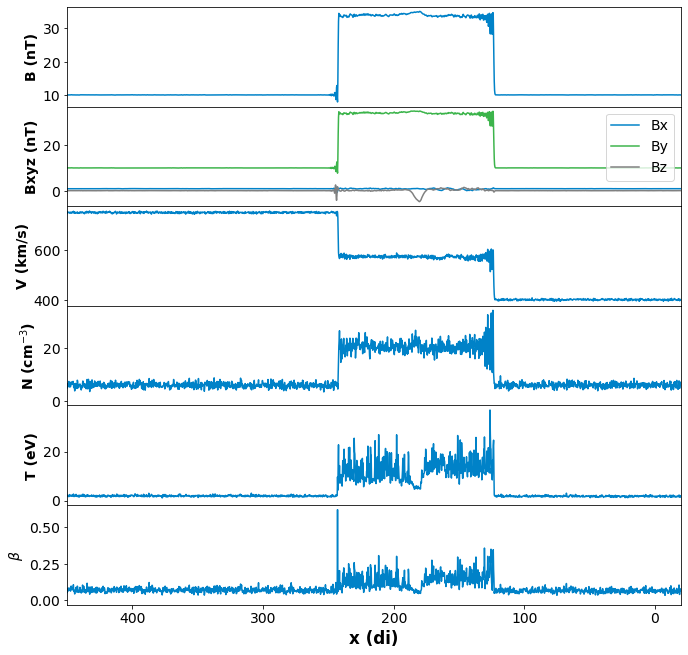

<Figure size 792x792 with 0 Axes>

In [445]:
b_norm = MD.norm((B[0][:, ny0, nz0], B[1][:, ny0, nz0], B[2][:, ny0, nz0]))
v_norm = MD.norm((V[0][:, ny0, nz0], V[1][:, ny0, nz0], V[2][:, ny0, nz0]))

e_th = (3/2)*MD.kB*MD.n*N[:, ny0, nz0]*MD.t*T[:, ny0, nz0]
e_mag = (b*MD.norm(B)[:, ny0, nz0])**2/(2*MD.µ0)
beta = e_th / e_mag

# def cm2inch(value):
#     return value / 2.54
# plt.figure(figsize=(cm2inch(21), cm2inch(29.7)))

flatui = ["#0082c8" , "#3cb44b", "#808080", "#e74c3c", "#34495e", "#2ecc71"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=flatui)
    
rcParams["figure.figsize"] = [11, 11]
gs = GridSpec(6, 1)
fsize = 14

axe = plt.subplot(gs[0])
plt.plot(x, b_norm)
plt.ylabel('B (nT)', fontsize=fsize)
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[1], sharex=axe)
plt.plot(x[:], B[0][:, ny0, nz0], label='Bx')
plt.plot(x[:], B[1][:, ny0, nz0], label='By')
plt.plot(x[:], B[2][:, ny0, nz0], label='Bz')
plt.legend(loc="upper right")
plt.ylabel('Bxyz (nT)', fontsize=fsize)
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[2], sharex=axe)
plt.plot(x[:], v_norm)
plt.ylabel('V (km/s)', fontsize=fsize)
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[3], sharex=axe)
plt.plot(x[:], N[:, ny0, nz0])
plt.ylabel(r'N (cm$^{-3}$)', fontsize=fsize)
axe.get_xaxis().set_visible(False)
         
axe = plt.subplot(gs[4], sharex=axe)
plt.plot(x[:], T[:, ny0, nz0])
plt.ylabel('T (eV)', fontsize=fsize)
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[5], sharex=axe)
plt.plot(x[:], beta)
plt.ylabel(r'$\beta$', fontsize=fsize)

plt.xlim([450, -20])
plt.xlabel('x (di)', fontsize=fsize*1.2, weight='bold')
plt.subplots_adjust(hspace=0)

# fileout = "global_view_sheath_"+run_name
# plt.savefig(filepath_out + fileout, dpi=150)
# print('Figure saved as ', filepath_out + fileout)

plt.figure()

### General view showing $U_z$ and $E_x$

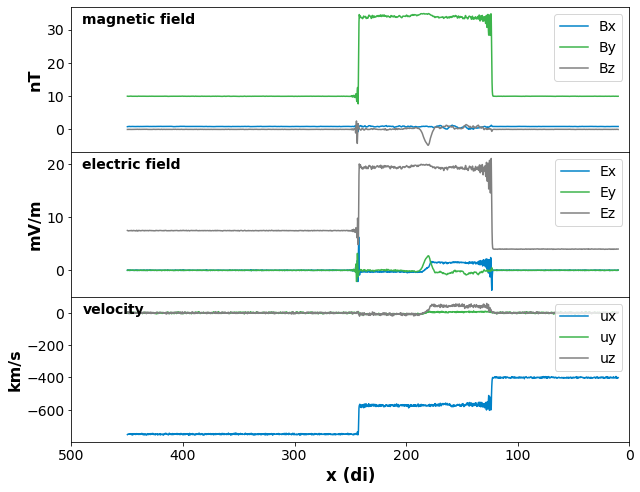

In [446]:
x_slice = slice(np.where(x==10)[0][0], np.where(x==450)[0][0])
y_slice = slice(ny0-1, ny0+1)
z_slice = slice(nz0-1, nz0+1)

y_slice_2 = slice(2, len(y)-2)
z_slice_2 = slice(2, len(z)-2)

slices = (x_slice, y_slice, z_slice)
slices_2 = (x_slice, y_slice_2, z_slice_2)

def smooth(A):
    return np.mean(A[slices_2], axis=(1,2))

def add_text(axe, text_string):
    gca_xlen = axe.get_xlim()[1] - axe.get_xlim()[0]
    gca_xmax = axe.get_xlim()[0]
    gca_ylen = axe.get_ylim()[1] - axe.get_ylim()[0]
    gca_ymax = axe.get_ylim()[1]
    axe.text(gca_xmax+gca_xlen*0.02,
             gca_ymax-gca_ylen*0.04,
             text_string,weight='bold',horizontalalignment='left', verticalalignment='top')

rcParams["figure.figsize"] = [10, 8]
gs = GridSpec(3, 1)

axe = plt.subplot(gs[0])
plt.plot(x[x_slice], B[0][x_slice, ny0, nz0], label='Bx')
plt.plot(x[x_slice], B[1][x_slice, ny0, nz0], label='By')
plt.plot(x[x_slice], B[2][x_slice, ny0, nz0], label='Bz')
plt.legend(loc = 'upper right')
plt.xlim(500,0)
add_text(axe, "magnetic field")
plt.ylabel("nT")
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[1], sharex=axe)
plt.plot(x[x_slice], E[0][x_slice, ny0, nz0], label='Ex')
plt.plot(x[x_slice], E[1][x_slice, ny0, nz0], label='Ey')
plt.plot(x[x_slice], E[2][x_slice, ny0, nz0], label='Ez')
plt.legend(loc = 'upper right')
add_text(axe, "electric field")
plt.ylabel("mV/m")
axe.get_xaxis().set_visible(False)


axe = plt.subplot(gs[2], sharex=axe)
plt.plot(x[x_slice], V[0][x_slice, ny0, nz0], label='ux')
plt.plot(x[x_slice], V[1][x_slice, ny0, nz0], label='uy')
plt.plot(x[x_slice], V[2][x_slice, ny0, nz0], label='uz')
add_text(axe, "velocity")
plt.ylabel("km/s")
plt.legend(loc = 'upper right')

plt.xlabel('x (di)', fontsize=fsize*1.2, weight='bold')
plt.subplots_adjust(hspace=0)

# fileout = "zoom_view_sheath_"+run_name
# plt.savefig(filepath_out + fileout, dpi=150)
# print('Figure saved as ', filepath_out + fileout)

plt.show()

### Why Vz?

In [447]:
x_slice = slice(10,760)
y_slice = slice(ny0-1, ny0+1)
z_slice = slice(nz0-1, nz0+1)

y_slice_2 = slice(2, len(y)-2)
z_slice_2 = slice(2, len(z)-2)

slices = (x_slice, y_slice, z_slice)
slices_2 = (x_slice, y_slice_2, z_slice_2)

def smooth(A):
    return np.mean(A[slices_2], axis=(1,2))

#### Rankine-Hugoniot

##### Move to the Hoffmann-Teller frame

In [448]:
round_x = np.array([round(xi) if isclose(xi,round(xi),abs_tol=0.001) else xi for xi in x])
# print(x[np.where(x>=106.75)])
# print(round_x[np.where(x>=106.75)])

In [455]:
#Ugly hard code
shock_position = 108 #for '20_05_18_event_only'
shock_position = 118 #for 'dx=0.5 and t=225'
# shock_position = 124 #for 'dx=0.4, t=185'
# shock_position = 128 #for 'dx=0.25, t=125'
# shock_position = 53  #for 'dx=0.2, t=115'
shock_position = 122
i_shock_position = np.where(round_x==shock_position)[0][0]

upstream_slice   = slice(i_shock_position-int(45/gstep[0]),i_shock_position-int(30/gstep[0]))
downstream_slice = slice(i_shock_position+int(30/gstep[0]),i_shock_position+int(45/gstep[0]))

In [456]:
x_slice = slice(i_shock_position-int(50/gstep[0]),i_shock_position+int(50/gstep[0]))
y_slice = slice(ny0-1, ny0+1)
z_slice = slice(nz0-1, nz0+1)

y_slice_2 = slice(2, len(y)-2)
z_slice_2 = slice(2, len(z)-2)

slices = (x_slice, y_slice, z_slice)
slices_2 = (x_slice, y_slice_2, z_slice_2)

def smooth(A, xslice=x_slice, yslice=y_slice_2, zslice=z_slice_2):
    slices_ = (xslice, yslice, zslice)
    return np.mean(A[slices_], axis=(1,2))

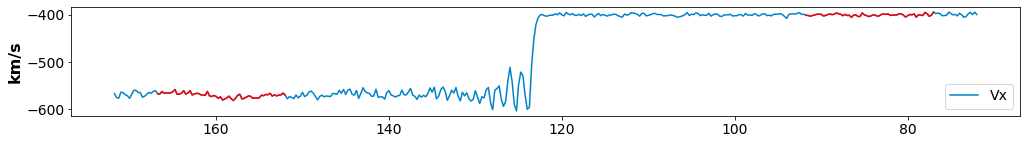

In [457]:
rcParams["figure.figsize"] = [17, 2]

plt.plot(x[x_slice], Vx[x_slice, ny0, nz0], label="Vx")
plt.plot(x[upstream_slice  ], Vx[upstream_slice, ny0, nz0], color="red")
plt.plot(x[downstream_slice], Vx[downstream_slice, ny0, nz0], color="red")
plt.ylabel('km/s')
plt.legend(loc='lower right')
plt.gca().invert_xaxis()

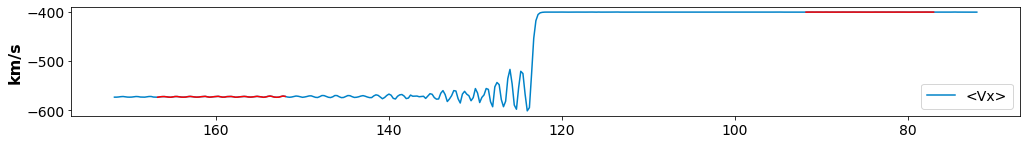

In [458]:
rcParams["figure.figsize"] = [17, 2]

plt.plot(x[x_slice], smooth(Vx), label="<Vx>")
plt.plot(x[upstream_slice  ], np.mean(Vx[upstream_slice  , y_slice_2, z_slice_2], axis=(1,2)), color="red")
plt.plot(x[downstream_slice], np.mean(Vx[downstream_slice, y_slice_2, z_slice_2], axis=(1,2)), color="red")
plt.ylabel('km/s')
plt.legend(loc='lower right')
plt.gca().invert_xaxis()

In [459]:
v_up = np.nanmean(Vx[upstream_slice, y_slice_2, z_slice_2])
print(f"v_upstream = {v_up:0.0f} km/s")

v_down = np.nanmean(Vx[downstream_slice, y_slice_2, z_slice_2])
print(f"v_downstream = {v_down:0.0f} km/s")

n_up = np.nanmean(N[upstream_slice, y_slice_2, z_slice_2])
print(f"n_upstream = {n_up:0.0f} ions/cm^3")

n_down = np.nanmean(N[downstream_slice, y_slice_2, z_slice_2])
print(f"n_downstream = {n_down:0.0f} ions/cm^3")

v_upstream = -400 km/s
v_downstream = -572 km/s
n_upstream = 6 ions/cm^3
n_downstream = 20 ions/cm^3


In [460]:
V_HF = (n_up*v_up - n_down*v_down)/(n_up - n_down)

print(f'V_Hoffman-Teller = {V_HF:0.0f} km/s')

V_Hoffman-Teller = -644 km/s


In [461]:
Vx_hf = Vx - V_HF

##### Estimate signal frequency in the downstream region

In [462]:
T_down = np.nanmean(T[downstream_slice, y_slice_2, z_slice_2])
vth_down = np.sqrt(3*MD.kB*T_down*MD.t/MD.mp)
B_down = np.nanmean(MD.norm(B)[downstream_slice, y_slice_2, z_slice_2])
v_down_hf_frame = v_down - V_HF

print(f"T_down = {T_down*MD.t:.2e} K")
print(f"vth_down = {vth_down/MD.v:.0f} km/s")
print(f"v_down_hf_frame = {v_down_hf_frame:.0f} km/s")
print(f"B_down = {B_down:.0f} nT")

wci_down = MD.qe*B_down*MD.b / MD.mp
print(f"wci_downstream = {wci_down:0.1f} rad/s")

rL_down = vth_down / wci_down
print(f"rL_down = {rL_down*1e-3:0.1f} km")

print("\n")

T_up = np.nanmean(T[upstream_slice, y_slice_2, z_slice_2])
vth_up = np.sqrt(3*MD.kB*T_up*MD.t/MD.mp)
B_up = np.nanmean(MD.norm(B)[upstream_slice, y_slice_2, z_slice_2])
v_up_hf_frame = v_up - V_HF

print(f"T_up = {T_up*MD.t:.2e} K")
print(f"vth_up = {vth_up/MD.v:.0f} km/s")
print(f"v_up_hf_frame = {v_up_hf_frame:.0f} km/s")
print(f"B_up = {B_up:.0f} nT")

wci_up = MD.qe*B_up*MD.b / MD.mp
print(f"wci_upstream = {wci_up:0.1f} rad/s")

rL_up = vth_up / wci_up
print(f"rL_up = {rL_up*1e-3:0.1f} km")

T_down = 1.55e+05 K
vth_down = 62 km/s
v_down_hf_frame = 72 km/s
B_down = 34 nT
wci_downstream = 3.2 rad/s
rL_down = 19.1 km


T_up = 2.03e+04 K
vth_up = 22 km/s
v_up_hf_frame = 244 km/s
B_up = 10 nT
wci_upstream = 1.0 rad/s
rL_up = 23.4 km


In [463]:
T_cyclotron = 2*pi / wci_down
print(f"T_cyclotron = {2*T_cyclotron:0.2f} s")

# dt_half_gyration = pi*rL_down / vth_down
# print(dt_half_gyration)

d_guiding_center = v_down_hf_frame * T_cyclotron

print(f"lambda_c = {d_guiding_center:0.2f} km")

print(f"since cwp = {cwp[0]:0.2f} km, we have:")

print(f"lambda_c_in_di = {d_guiding_center / cwp[0]:0.2f}")

T_cyclotron = 3.88 s
lambda_c = 139.33 km
since cwp = 92.63 km, we have:
lambda_c_in_di = 1.50


In [464]:
np.mean(Ez[downstream_slice]*1e-3), v_down*1e3*B_down*1e-9

(0.019364126, -0.019369645037365147)

In [465]:
dv_critical = (np.pi/2)*(np.mean(2*1e-3) / (B_down*1e-9)) #where 2 is the amplitude of the Ex oscillations
#This is an estimation of the dv gained or lost in a quarter of a gyroperiod due to the qEx force
print(f"dv_critical = {dv_critical*1e-3:.0f} km/s") 

dv_critical = 93 km/s


In [466]:
Ez_down_HF = (v_down-V_HF)*1e3*B_down*1e-9
print(f"Ez_down_HF = {Ez_down_HF*1e3:0.2f}")

Ez_down_HF = 2.43


In [467]:
B_down

33.843876

In [468]:
ne = np.array(N[:])
Te = np.mean(T[50:150, ny0, nz0]) * (ne/6)**(2/3) #eV

In [469]:
np.mean(T[50:150, ny0, nz0])

1.7626779

In [470]:
np.mean(Te)

2.0061164

In [471]:
Pe = (3/2)*MD.kB*np.array(ne*n*Te*MD.t)

(171.75, 107)

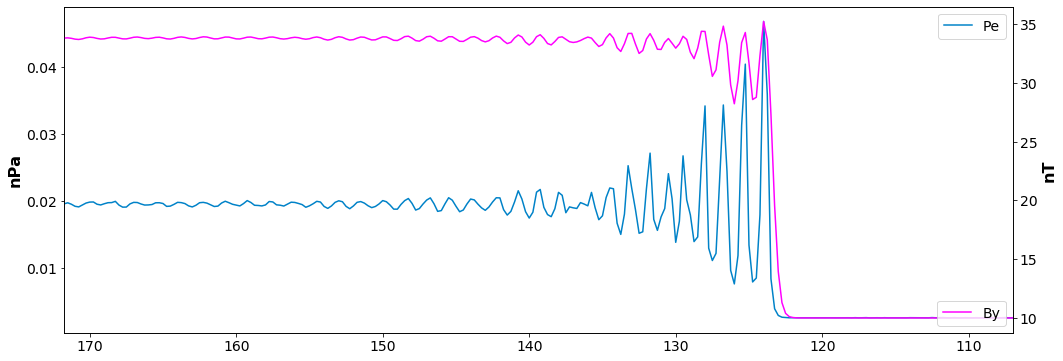

In [472]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Pe)*1e9, label="Pe")
plt.legend(loc='upper right')
plt.ylabel('nPa')
ax2=ax.twinx()
ax2.plot(x[x_slice], smooth(By), label='By', color="magenta")
plt.legend(loc='lower right')
plt.ylabel('nT')
plt.xlim([max(x[x_slice]),shock_position-15])


In [473]:
p_dyn = MD.mp * (n*ne) * (v*(Vx-V_HF))**2 
p_mag = (b*MD.norm(B))**2/(2*MD.µ0)
p_th  = (3/2)*MD.kB*(n*N)*(MD.t*T)

In [474]:
print(np.nanmean(p_dyn))
print(np.mean(p_mag))
print(np.mean(p_th))
print(np.mean(Pe))

2.5200772e-10
1.0310083e-10
1.1261782e-11
4.9399022e-12


(171.75, 107)

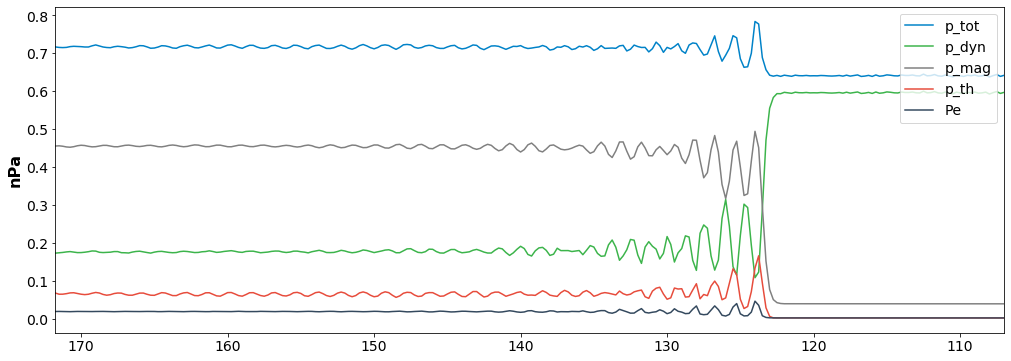

In [475]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(1e9*p_dyn)+smooth(1e9*p_mag)+smooth(1e9*p_th)+smooth(1e9*Pe), label="p_tot")
ax.plot(x[x_slice], smooth(1e9*p_dyn), label="p_dyn")
ax.plot(x[x_slice], smooth(1e9*p_mag), label="p_mag")
ax.plot(x[x_slice], smooth(1e9*p_th), label="p_th")
ax.plot(x[x_slice], smooth(1e9*Pe), label="Pe")
plt.legend(loc='upper right')
plt.ylabel('nPa')
plt.xlim([max(x[x_slice]),shock_position-15])


# fileout = "pressure_oscillations"+"dx=half"
# plt.savefig(filepath_out + fileout, dpi=150)
# print('Figure saved as ', filepath_out + fileout)

##### Mach number

In [476]:
B_up = np.nanmean(MD.norm(B, slice_=(upstream_slice, y_slice_2, z_slice_2)))
print(f"B_upstream = {B_up:0.0f} nT")

print(f"v_upstream = {v_up:0.0f} km/s")
print(f'V_Hoffman-Teller = {V_HF:0.0f} km/s')

vA_up = B_up*MD.b / sqrt(MD.µ0 * MD.mp * n_up*MD.n)
print(f"upstream Alfvén speed = {vA_up/MD.v:0.0f} km/s")

MA_ips = (abs(V_HF)-abs(v_up)) / (vA_up/MD.v)
print(f"Shock's Mach number = {MA_ips:0.1f}")

B_upstream = 10 nT
v_upstream = -400 km/s
V_Hoffman-Teller = -644 km/s
upstream Alfvén speed = 89 km/s
Shock's Mach number = 2.7


##### Rankine Hugoniot

\begin{equation}
\begin{split}
    \text{Absence of magnetic monopoles:} \ \ \ \ & \left[ B_n \right] = 0 \\
    \text{Continuity equation:} \ \ \ \ & \left[ \rho u_n \right] = 0 \\
    \text{Maxwell-Faraday:} \ \ \ \ & \left[ u_n B_{t1} - u_{t1} B_n \right] = 0 \ \ \ \& \ \ \ \left[ u_n B_{t2} - u_{t2} B_n \right] = 0 \\
    \text{Equation of motion:} \ \ \ \ & \left[ \frac{1}{2}\rho u_n \vec{u} + (P_\text{th} + \frac{B^2}{2 \mu_0}) \vec{e}_n - \frac{B_n \vec{B}}{\mu_0} \right] = 0 \\
\end{split}
\end{equation}

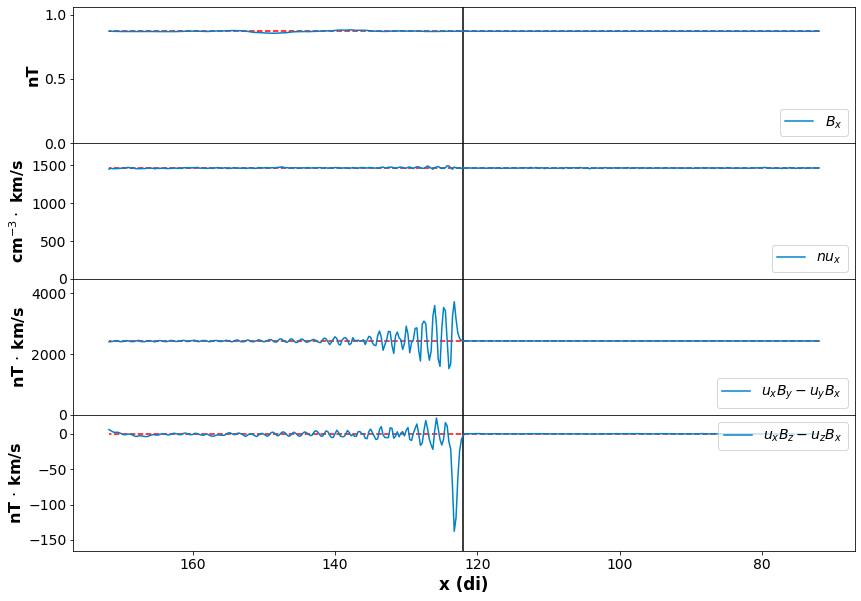

In [477]:
n_plots = 5

rcParams["figure.figsize"] = [14, n_plots*2.5]
matplotlib.rcParams.update({'font.size': 15})

gs = GridSpec(n_plots, 1)

data = smooth(Bx)
axe = plt.subplot(gs[0])
plt.plot(x[x_slice], np.ones(len(x[x_slice]))*np.nanmean(Bx[upstream_slice, y_slice_2, z_slice_2]), color='red', linestyle="--")
plt.plot(x[x_slice], smooth(Bx), label=r'$B_x$')
plt.legend(loc='lower right')
plt.ylabel("nT")
axe.get_xaxis().set_visible(False)
axe.set_ylim([min(0, min(data)*1.2), max(data*1.2)])
plt.vlines(shock_position, axe.get_ylim()[0], axe.get_ylim()[1])
                                                             
data = smooth(N*Vx_hf)
axe = plt.subplot(gs[1], sharex=axe)
plt.plot(x[x_slice], np.ones(len(x[x_slice]))*np.nanmean((N*Vx_hf)[upstream_slice, y_slice_2, z_slice_2]), color='red', linestyle="--")
plt.plot(x[x_slice], data, label=r'$n u_x$')
plt.legend(loc='lower right')
plt.ylabel(r'cm$^{-3} \cdot$ km/s')
axe.get_xaxis().set_visible(False)
axe.set_ylim([min(0, min(data)*1.2), max(data*1.2)])
plt.vlines(shock_position, axe.get_ylim()[0], axe.get_ylim()[1])

data = smooth(Vx_hf*By - Vy*Bx)
axe = plt.subplot(gs[2], sharex=axe)
plt.plot(x[x_slice], np.ones(len(x[x_slice]))*np.nanmean((Vx_hf*By - Vy*Bx)[upstream_slice, y_slice_2, z_slice_2]), color='red', linestyle="--")
plt.plot(x[x_slice], data, label=r'$u_x B_{y} - u_{y} B_x$')
plt.legend(loc='lower right')
plt.ylabel(r"nT $\cdot$ km/s")
axe.get_xaxis().set_visible(False)
axe.set_ylim([min(0, min(data)*1.2), max(data*1.2)])
plt.vlines(shock_position, axe.get_ylim()[0], axe.get_ylim()[1])

data = smooth(Vx_hf*Bz - Vz*Bx)
axe = plt.subplot(gs[3], sharex=axe)
plt.plot(x[x_slice], np.ones(len(x[x_slice]))*np.nanmean((Vx_hf*Bz - Vz*Bx)[upstream_slice, y_slice_2, z_slice_2]), color='red', linestyle="--")
plt.plot(x[x_slice], data, label=r'$u_x B_{z} - u_{z} B_x$')
plt.legend(loc='upper right')
plt.ylabel(r"nT $\cdot$ km/s")
axe.set_ylim([min(0, min(data)*1.2), max(data*1.2)])
plt.vlines(shock_position, axe.get_ylim()[0], axe.get_ylim()[1])

# rcParams["figure.figsize"] = [17, 4]
# plt.figure()
# axe = plt.subplot(sharex=axe)
# plt.plot(x[x_slice], smooth(  (1/2)*MD.mp*N*n*(v*Vx_hf)**2 \
#                             + MD.kB*N*n*T*MD.t       \
#                             + (MD.norm(B)*b)**2/(2*MD.µ0) - (b*Bx)**2/MD.µ0) \
# , label=r'$ \frac{1}{2}\rho u_n \vec{u} + (P_{th} + \frac{B^2}{2 \mu_0}) \vec{e}_n - \frac{B_n \vec{B}}{\mu_0}$')
# plt.plot(x[x_slice], smooth((1/2)*MD.mp*N*n*(v*Vx_hf)**2), label='Pdyn')
# plt.plot(x[x_slice], smooth(MD.kB*N*n*T*MD.t), label='Pth')
# plt.plot(x[x_slice], smooth((MD.norm(B)*b)**2/(2*MD.µ0) - (b*Bx)**2/MD.µ0), label='Pmag')  # - (b*Bx)**2/MD.µ0
# plt.legend(loc='upper right')
# axe.set_ylim(bottom=0)

plt.gca().invert_xaxis()
plt.xlabel('x (di)', fontsize=fsize*1.2, weight='bold')
plt.subplots_adjust(hspace=0)

# fileout = "Rankine_Hugoniot_"+run_name
# plt.savefig(filepath_out + fileout, dpi=150)
# print('Figure saved as ', filepath_out + fileout)



#### Ohm's law

$$ E = - v_i \times B + \frac{j \times B}{n_e e} - \frac{\nabla \cdot P_e}{n_e e}$$

##### Preliminary computations & definitions

In [478]:
i = 0

In [479]:
advection = -MD.b*v*MD.cross_product(V, B, slice_=slices)[i]
advection = np.mean(advection, axis=(1,2))

Hall = j*MD.b/n*MD.cross_product(J, B, slice_=slices)[i] * (1/(qe*N[slices]))
Hall = np.mean(Hall, axis=(1,2))

vector_Pe = np.sqrt(1/3)*np.array([Pe, Pe, Pe])

pressure = - (MD.gradient(vector_Pe)/(cwp*1e3) / (qe*N*n)) [i][x_slice, ny0, nz0]

Ohm = advection + Hall + pressure 

In [480]:
advection_2 = -MD.b*v*MD.cross_product(V, B, slice_=slices_2)[i]
advection_2 = np.mean(advection_2, axis=(1,2))

Hall_2 = j*MD.b/n*MD.cross_product(J, B, slice_=slices_2)[i] * (1/(qe*N[slices_2]))
Hall_2 = np.mean(Hall_2, axis=(1,2))

vector_Pe = np.sqrt(1/3)*np.array([Pe, Pe, Pe])

pressure_2 = - (MD.gradient(vector_Pe)/(cwp*1e3) / (qe*N*n)) [i][slices_2]
pressure_2 = np.mean(pressure_2, axis=(1,2))

Ohm_2 = advection_2 + Hall_2 + pressure_2

##### Plots

(171.75, 107)

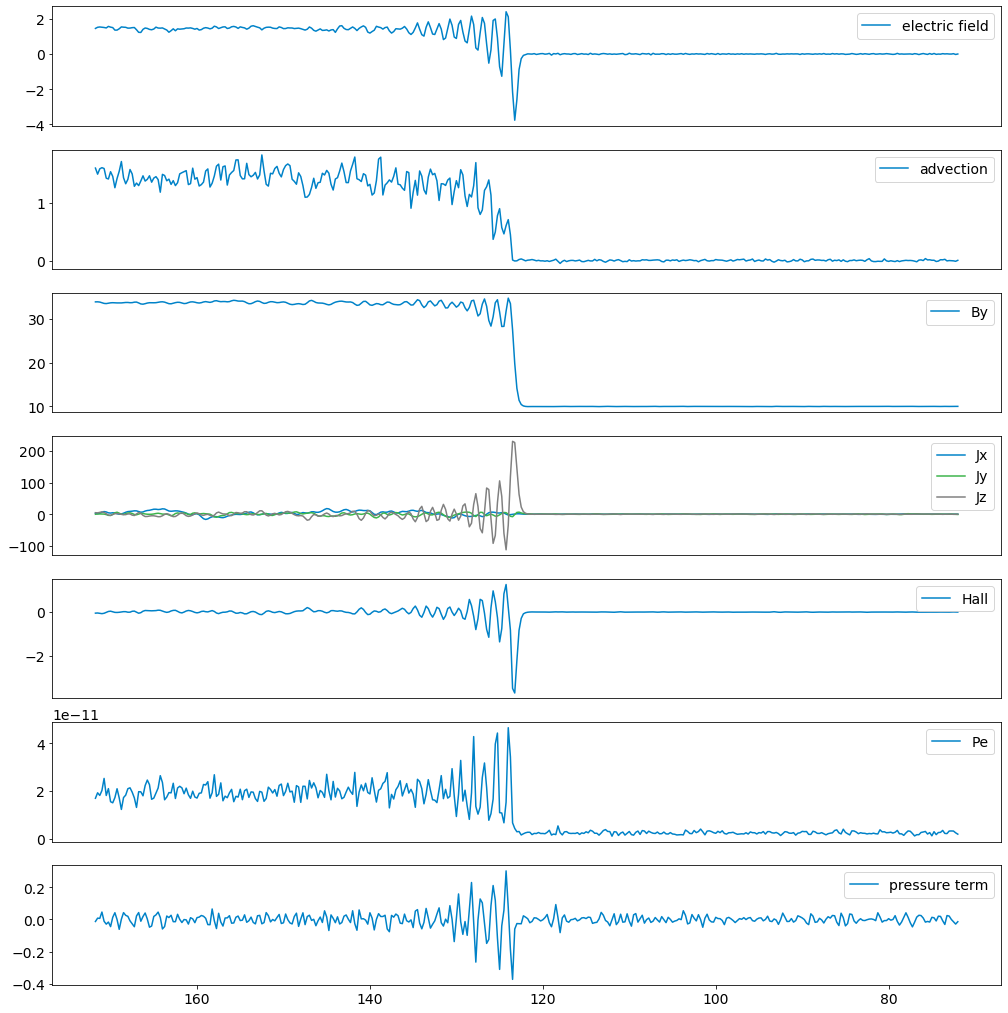

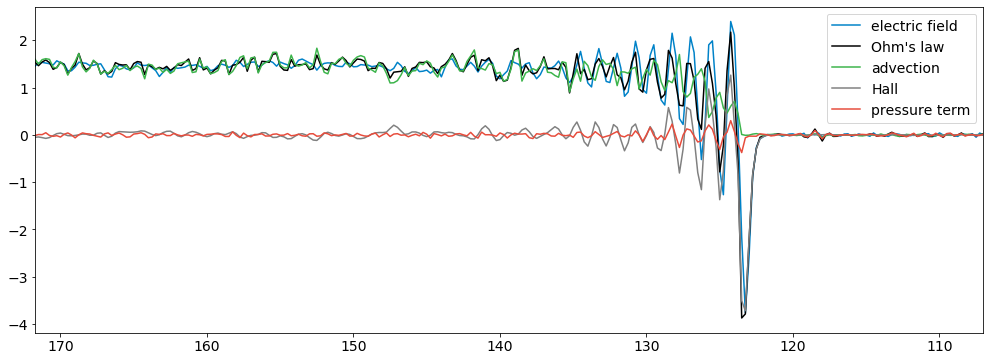

In [481]:
rcParams["figure.figsize"] = [17, 18]

gs = GridSpec(7, 1)

axe = plt.subplot(gs[0])
plt.plot(x[x_slice], Ex[x_slice, ny0, nz0], label='electric field')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[1], sharex=axe)
plt.plot(x[x_slice], e*advection, label='advection')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[2], sharex=axe)
plt.plot(x[x_slice], By[x_slice, ny0, nz0], label='By')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[3], sharex=axe)
plt.plot(x[x_slice], np.mean(MD.Jx(B, slices), axis=(1,2)), label='Jx')
plt.plot(x[x_slice], np.mean(MD.Jy(B, slices), axis=(1,2)), label='Jy')
plt.plot(x[x_slice], np.mean(MD.Jz(B, slices), axis=(1,2)), label='Jz')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[4], sharex=axe)
plt.plot(x[x_slice], e*Hall, label='Hall')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[5], sharex=axe)
plt.plot(x[x_slice], Pe[x_slice, ny0, nz0], label='Pe')
plt.legend()
axe.get_xaxis().set_visible(False)

axe = plt.subplot(gs[6], sharex=axe)
plt.plot(x[x_slice], e*pressure, label='pressure term')
plt.legend()

plt.gca().invert_xaxis()

rcParams["figure.figsize"] = [17, 6]
plt.figure()
plt.plot(x[x_slice], E[i][x_slice, ny0, nz0], label='electric field')
plt.plot(x[x_slice], e*Ohm, label="Ohm's law", color="black")
plt.plot(x[x_slice], e*advection, label='advection')
plt.plot(x[x_slice], e*Hall, label='Hall')
plt.plot(x[x_slice], e*pressure, label='pressure term')
plt.legend(loc='upper right')

plt.xlim([max(x[x_slice]),shock_position-15])

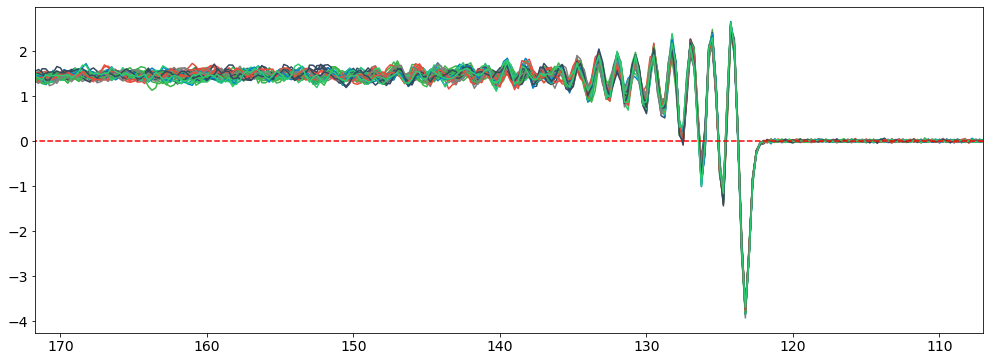

In [482]:
for iy in range(0, np.shape(E)[2], int(np.shape(E)[2]/5)):
    for iz in range(0, np.shape(E)[3], int(np.shape(E)[3]/5)):
        plt.plot(x[x_slice], E[i][x_slice, iy, iz], label='electric field')
        plt.xlim([max(x[x_slice]),shock_position-15])
plt.plot(x[x_slice], np.ones(len(x[x_slice]))*np.nanmean(Ex[upstream_slice, y_slice_2, z_slice_2]), color='red', linestyle="--")

In [483]:
# %matplotlib notebook

(171.75, 107)

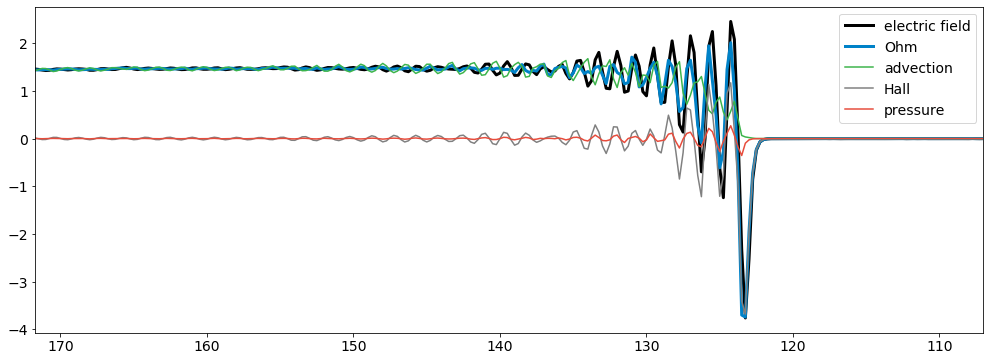

In [484]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], np.mean(E[i][slices_2], axis=(1,2)), label='electric field', color='black', linewidth=3)
ax.plot(x[x_slice], e*Ohm_2, label='Ohm', linewidth=3)
ax.plot(x[x_slice], e*advection_2, label='advection')
ax.plot(x[x_slice], e*Hall_2, label='Hall')
ax.plot(x[x_slice], e*pressure_2, label='pressure')
plt.legend(loc='upper right')
# ax2=ax.twinx()
# ax2.plot(x[x_slice], smooth(N), label='density', color="red")
# plt.legend(loc='lower right')
# plt.ylabel(r'cm$^{-3}$')
# ax2.set_ylim([-5*max(smooth(N)), 1.2*max(smooth(N))])
plt.xlim([max(x[x_slice]),shock_position-15])


# fileout = "Ohms_law_near_shock_smooth_dx_half"
# plt.savefig(filepath_out+ fileout, dpi=150)
# print('Figure saved as ', filepath_out + fileout)


In [485]:
number_of_wavelengths = 2
distance_between_first_and_last_peak = 134-128.2
lambda_c_simu = distance_between_first_and_last_peak / number_of_wavelengths

print(f"lambda_c_simu_in_di = {lambda_c_simu:0.2f}")

lambda_c_simu_in_di = 2.90


In [486]:
print("RESULT")
far_downstream_slice = slice(i_shock_position+int(45/gstep[0]),i_shock_position+int(55/gstep[0]))
print(f"far_downstream ranges from x={int(x[far_downstream_slice.start])} to \
x={int(x[far_downstream_slice.stop])} for shock at x={shock_position}")

vy_far_down = np.nanmean(Vy[far_downstream_slice, y_slice_2, z_slice_2])

print(f"vy_far_downstream = {vy_far_down:0.0f} km/s")
vz_far_down = np.nanmean(Vz[far_downstream_slice, y_slice_2, z_slice_2])
print(f"vz_far_downstream = {vz_far_down:0.0f} km/s")

Ex_far_down = np.nanmean(Ex[far_downstream_slice, y_slice_2, z_slice_2])
print(f"Ex_ar_downstream = {Ex_far_down:0.1f} mV/m")
Ey_far_down = np.nanmean(Ey[far_downstream_slice, y_slice_2, z_slice_2])
print(f"Ey_ar_downstream = {Ey_far_down:0.1f} mV/m")

RESULT
far_downstream ranges from x=167 to x=177 for shock at x=122
vy_far_downstream = 4 km/s
vz_far_downstream = 44 km/s
Ex_ar_downstream = 1.5 mV/m
Ey_ar_downstream = -0.2 mV/m


#### Understanding

(116.75, 52)

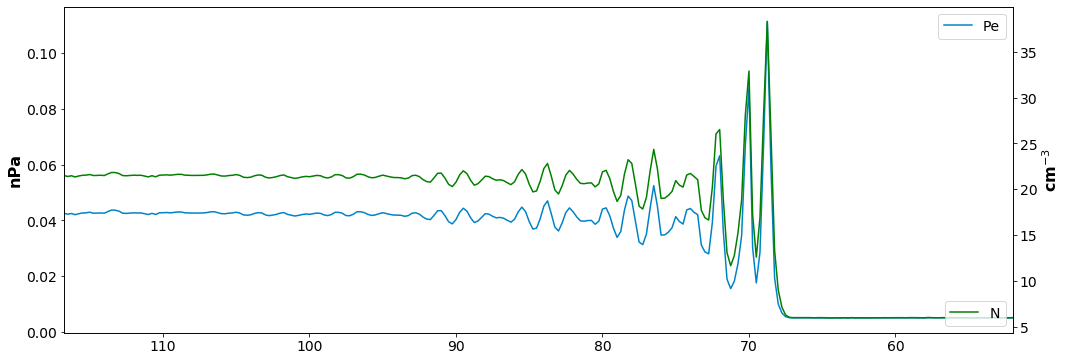

In [435]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Pe)*1e9, label="Pe")
plt.legend(loc='upper right')
plt.ylabel('nPa')
ax2=ax.twinx()
ax2.plot(x[x_slice], smooth(N), label='N', color="green")
plt.legend(loc='lower right')
plt.ylabel(r'cm$^{-3}$')
plt.xlim([max(x[x_slice]),shock_position-15])

(116.75, 52)

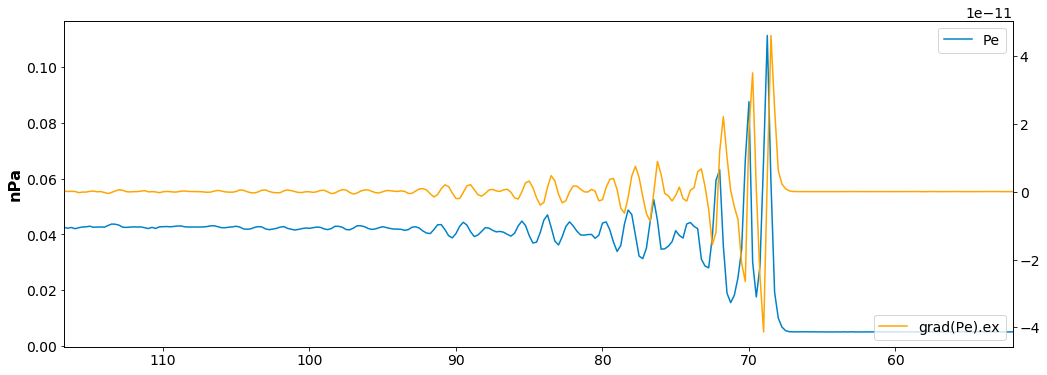

In [436]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Pe)*1e9, label="Pe")
plt.legend(loc='upper right')
plt.ylabel('nPa')
ax2=ax.twinx()
ax2.plot(x[x_slice], smooth(np.gradient(Pe)[i]), label='grad(Pe).ex', color="orange")
plt.legend(loc='lower right')
plt.xlim([max(x[x_slice]),shock_position-15])

(167.5, 103)

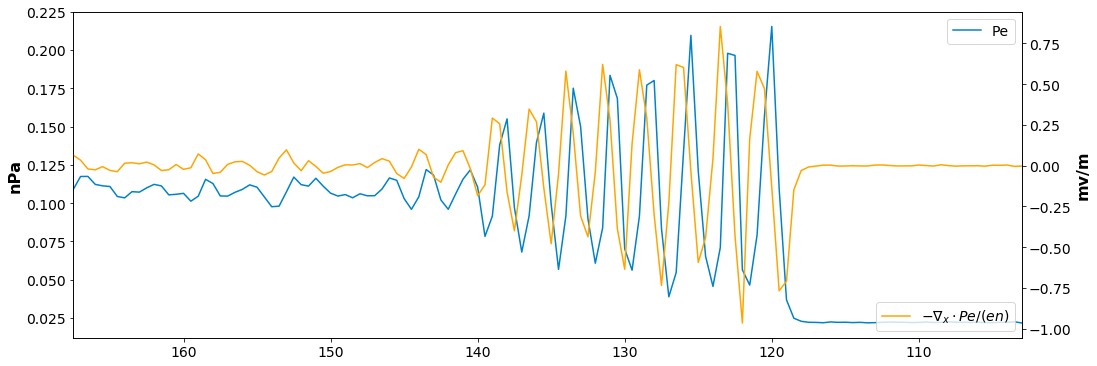

In [106]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Pe)*1e9, label="Pe")
plt.legend(loc='upper right')
plt.ylabel('nPa')
ax2=ax.twinx()
ax2.plot(x[x_slice], pressure_2*e, label=r'$-\nabla_x \cdot Pe / (e n)$', color="orange")
plt.legend(loc='lower right')
plt.ylabel('mv/m')
plt.xlim([max(x[x_slice]),shock_position-15])

(167.5, 103)

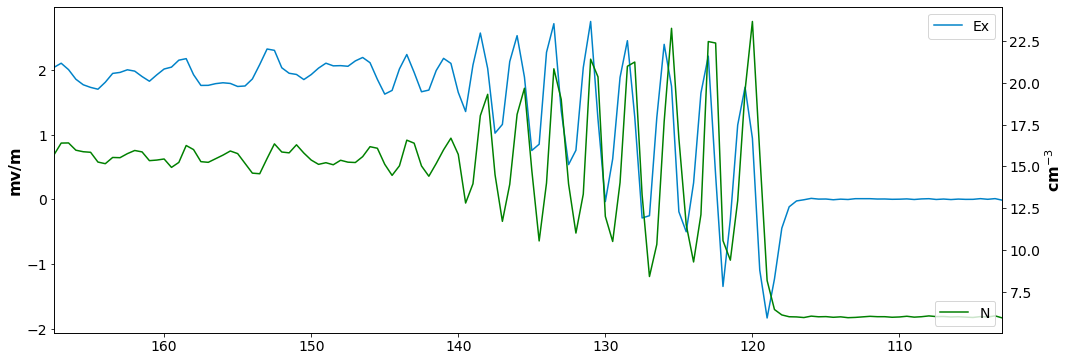

In [107]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Ex), label="Ex")
plt.ylabel('mv/m')
plt.legend(loc='upper right')
ax2=ax.twinx()
ax2.plot(x[x_slice], smooth(N), label='N', color="green")
plt.legend(loc='lower right')
plt.ylabel(r'cm$^{-3}$')
plt.xlim([max(x[x_slice]),shock_position-15])

(167.5, 103)

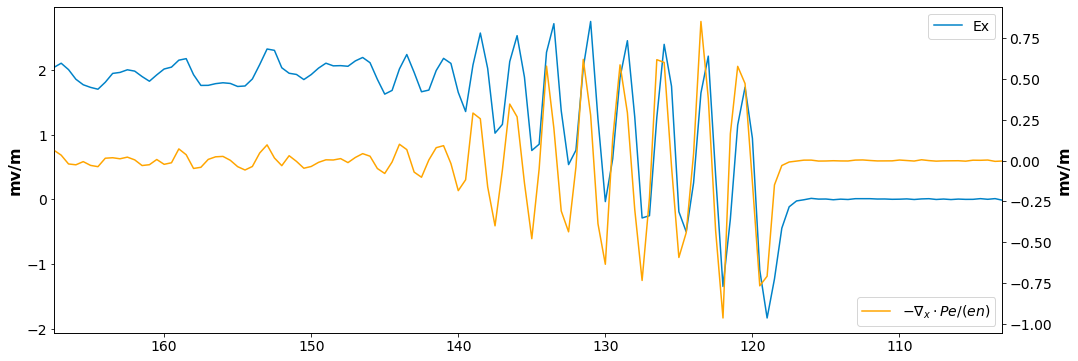

In [108]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Ex), label="Ex")
plt.ylabel('mv/m')
plt.legend(loc='upper right')
ax2=ax.twinx()
ax2.plot(x[x_slice], pressure_2*e, label=r'$-\nabla_x \cdot Pe / (e n)$', color="orange")
plt.legend(loc='lower right')
plt.ylabel('mv/m')
plt.xlim([max(x[x_slice]),shock_position-15])

(167.5, 103)

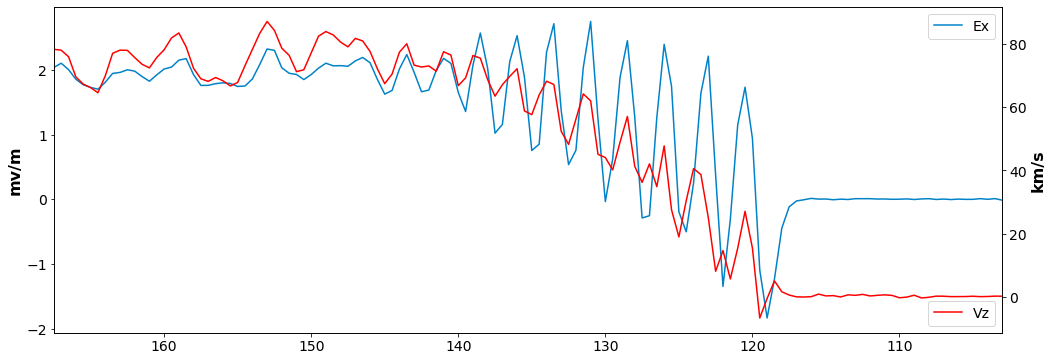

In [109]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Ex), label="Ex")
plt.ylabel('mv/m')
plt.legend(loc='upper right')
ax2=ax.twinx()
ax2.plot(x[x_slice], smooth(Vz), label='Vz', color="red")
plt.legend(loc='lower right')
plt.ylabel('km/s')
plt.xlim([max(x[x_slice]),shock_position-15])

(167.5, 103)

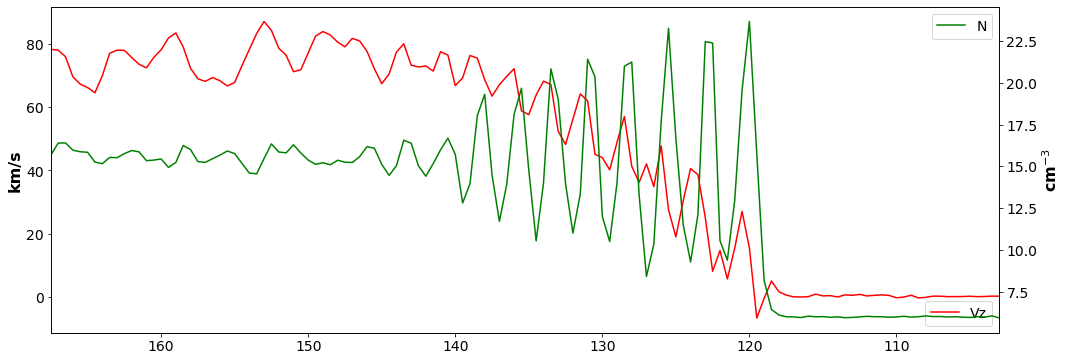

In [110]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Vz), label='Vz', color="red")
plt.legend(loc='lower right')
plt.ylabel('km/s')
ax2=ax.twinx()
ax2.plot(x[x_slice], smooth(N), label='N', color="green")
plt.ylabel(r'cm$^{-3}$')
plt.legend(loc='upper right')
plt.xlim([max(x[x_slice]),shock_position-15])

(167.5, 103)

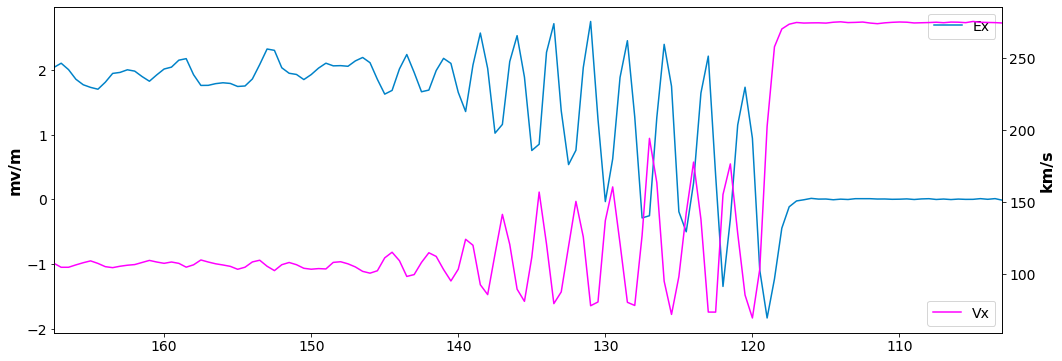

In [111]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.plot(x[x_slice], smooth(Ex), label="Ex")
plt.ylabel('mv/m')
plt.legend(loc='upper right')
ax2=ax.twinx()
ax2.plot(x[x_slice], smooth(Vx)-V_HF, label='Vx', color="magenta")
plt.legend(loc='lower right')
plt.ylabel('km/s')
plt.xlim([max(x[x_slice]),shock_position-15])

In [112]:
wci_down = MD.qe*B_down*MD.b / MD.mp
print(f"wci_downstream={wci_down}")

print(f"lambda={(2*pi/wci_down)*(v_down - V_HF) / cwp[0]}")

wci_downstream=2.4745884982440245
lambda=2.916075823663515


#### color maps

In [113]:
xmin = shock_position-30
xmax = shock_position+80   
zoom = (xmin, xmax, min(y), max(y), min(z), max(z))

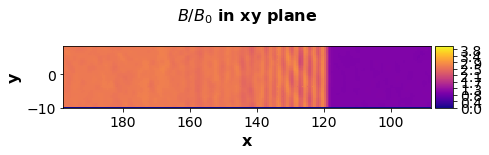

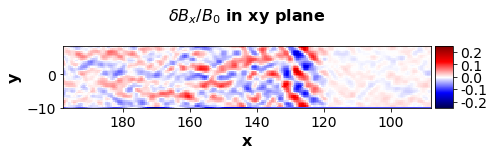

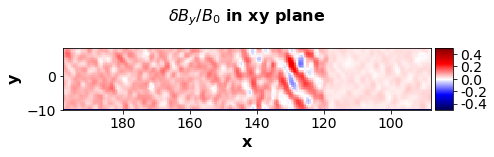

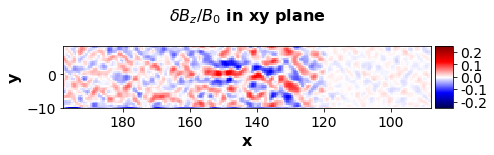

In [114]:
b = MD.norm(B)[:,:,nz0]
b0 = np.mean(b[xmin:xmax, :])
MD.plot_colormap(b/b0, title=r'$B/B_0$ in xy plane', label='', plane='xy', zoom=zoom)

bx = Bx[:,:,nz0]
bx0 = np.mean(bx[:, :], axis=1) #Average along y
bx0 = np.transpose(np.tile(bx0, (np.shape(bx)[1], 1)))
dbx = bx - bx0
MD.plot_colormap(dbx/b0, title=r'$\delta B_x/B_0$ in xy plane', label='', plane='xy', zoom=zoom, map_color='seismic', min_value=-0.25, max_value=0.25)

by = By[:,:,nz0]
by0 = np.mean(by[:, :], axis=1)
by0 = np.transpose(np.tile(by0, (np.shape(by)[1], 1)))
dby = by - by0
MD.plot_colormap(dby/b0, title=r'$\delta B_y/B_0$ in xy plane', label='', plane='xy', zoom=zoom, map_color='seismic', min_value=-0.5, max_value=0.5)

bz = Bz[:,:,nz0]
bz0 = np.mean(bz[:, :], axis=1)
bz0 = np.transpose(np.tile(bz0, (np.shape(bz)[1], 1)))
dbz = bz - bz0
MD.plot_colormap(dbz/b0, title=r'$\delta B_z/B_0$ in xy plane', label='', plane='xy', zoom=zoom, map_color='seismic', min_value=-0.25, max_value=0.25)

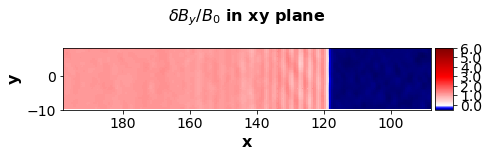

In [115]:
by = By[:,:,nz0]
by0 = np.mean(by[:, :], axis=0) #Average along x
by0 = np.tile(by0, (np.shape(by)[0],1))
dby = by - by0
MD.plot_colormap(dby/b0, title=r'$\delta B_y/B_0$ in xy plane', label='', plane='xy', zoom=zoom, map_color='seismic', min_value=-0.5, max_value=6)


In [116]:
wait_these_p3_figures_take_a_LOT_of_time

NameError: name 'wait_these_p3_figures_take_a_LOT_of_time' is not defined

#### p3 files

##### Download data

In [117]:
posx = []
posy = []
posz = []

velx = []
vely = []
velz = []

i = 0

filepath_p3 = filepath + 'p3_files/'

for p3_file in listdir(filepath_p3):
    
    if not(".nc" in p3_file):
        continue
    
    i+=1
        
    print("Reading file", i, "/", len(listdir(filepath_p3)), end="\r")
#    print("Reading ", p3_file, " ...", end="\r")

    p3_data = nc.Dataset(filepath_p3 + p3_file,'r')
    
    posx = posx + list(np.array(p3_data.variables['particule_x']))
    posy = posy + list(np.array(p3_data.variables['particule_y']))
    posz = posz + list(np.array(p3_data.variables['particule_z']))

    velx = velx + list(-np.array(p3_data.variables['particule_vx']))
    vely = vely + list(-np.array(p3_data.variables['particule_vy']))
    velz = velz + list(np.array(p3_data.variables['particule_vz']))


In [118]:
nx = len(x)
ny = len(y)
nz = len(z)
px = nx*MD.gstep[0] - 100
py = ny/2 * MD.gstep[1]
pz = nz/2 * MD.gstep[2]

def pos_gse(pos_simu, planet, sgn):
    return sgn*(np.array(pos_simu) - planet*np.ones(len(pos_simu)))

# Move from x_simu to x_gse
rposx = pos_gse(posx, px, -1)
rposy = pos_gse(posy, py, -1)
rposz = pos_gse(posz, pz,  1)

#### Crop dataset

In [119]:
xlims = (shock_position-15,shock_position+30)
ylims = (-100, 100)
zlims = (-100, 100)
print(xlims)

(103, 148)


In [120]:
def inregion(pos_part):
    x_part, y_part, z_part = pos_part
    return (    (xlims[0] < x_part < xlims[1]) 
            and (ylims[0] < y_part < ylims[1]) 
            and (zlims[0] < z_part < zlims[1]) )

In [121]:
x_parts = [rposx[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
y_parts = [rposy[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
z_parts = [rposz[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]

vA = 89.371 #Ugly hard code
vx_parts = [velx[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
vy_parts = [vely[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
vz_parts = [velz[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]

No handles with labels found to put in legend.


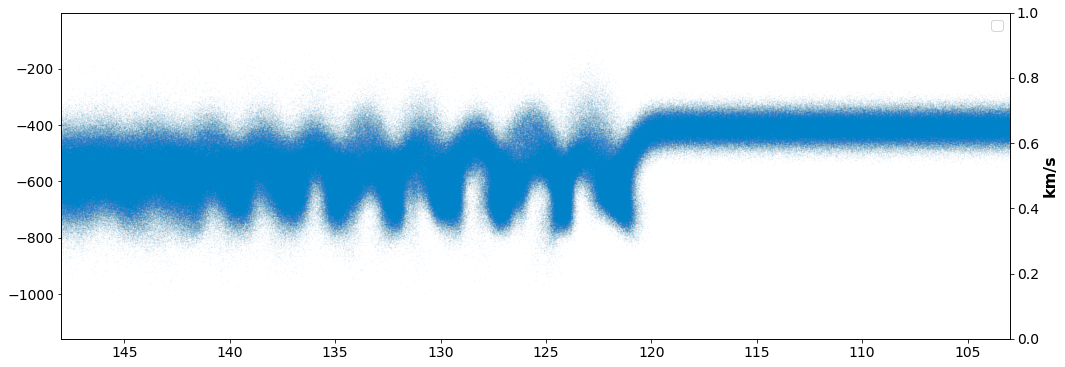

In [122]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.scatter(x_parts, vx_parts, s = 0.01*60000/len(x_parts))
plt.xlim(xlims[1], xlims[0])
ax2=ax.twinx()
# ax2.plot(x[x_slice], smooth(Vx), label='Vx', color="red")
plt.ylabel('km/s')
plt.legend(loc='upper right')

plt.show()

No handles with labels found to put in legend.


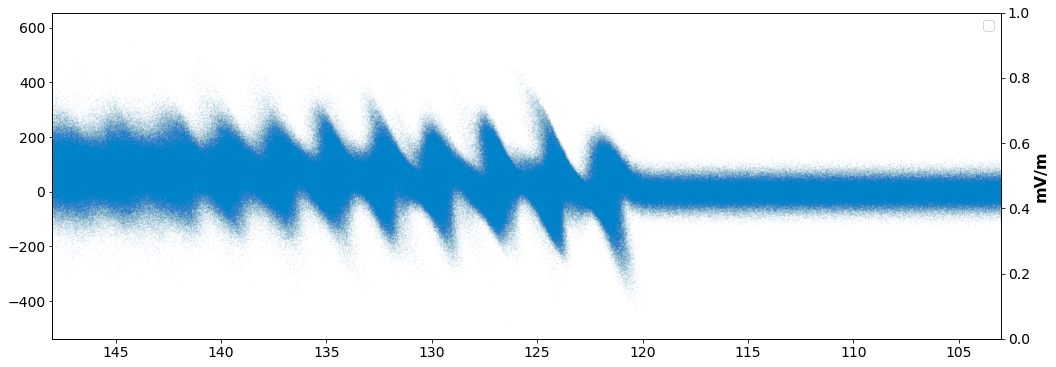

In [123]:
rcParams["figure.figsize"] = [17, 6]
fig,ax = plt.subplots()
ax.scatter(x_parts, vz_parts, s = 0.01*60000/len(x_parts))
plt.xlim(xlims[1], xlims[0])
ax2=ax.twinx()
# ax2.plot(x[x_slice], smooth(Ex), label='Ex', color="red")
plt.ylabel('mV/m')
plt.legend(loc='upper right')

plt.show()


In [124]:
#just downstream

xlims = (shock_position+2,shock_position+4)
ylims = (-10, 10)
zlims = (-10, 10)
print(xlims)

def inregion(pos_part):
    x_part, y_part, z_part = pos_part
    return (    (xlims[0] < x_part < xlims[1]) 
            and (ylims[0] < y_part < ylims[1]) 
            and (zlims[0] < z_part < zlims[1]) )

x_parts = [rposx[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
y_parts = [rposy[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
z_parts = [rposz[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]

vA = 89.371 #Ugly hard code
vx_parts = [velx[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
vy_parts = [vely[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
vz_parts = [velz[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]

vxmean = np.mean(vx_parts)
vzmean = np.mean(vz_parts)

(120, 122)


In [125]:
len(x_parts)

118830

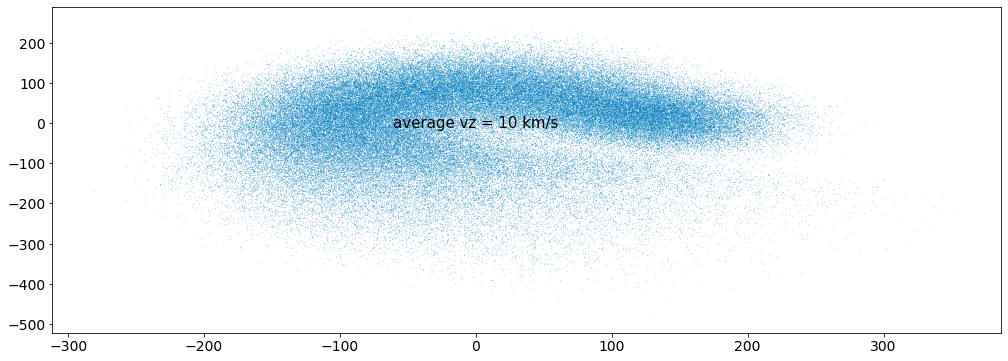

In [126]:
plt.scatter(vx_parts - vxmean, vz_parts - vzmean, s = 0.7*1427/len(x_parts))
plt.text(0,0, f"average vz = {vzmean:0.0f} km/s", horizontalalignment='center', verticalalignment='center')
plt.show()

In [127]:
#further downstream

xlims = (shock_position+12,shock_position+14)
ylims = (-10, 10)
zlims = (-10, 10)
print(xlims)

def inregion(pos_part):
    x_part, y_part, z_part = pos_part
    return (    (xlims[0] < x_part < xlims[1]) 
            and (ylims[0] < y_part < ylims[1]) 
            and (zlims[0] < z_part < zlims[1]) )

x_parts = [rposx[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
y_parts = [rposy[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
z_parts = [rposz[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]

vA = 89.371 #Ugly hard code
vx_parts = [velx[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
vy_parts = [vely[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
vz_parts = [velz[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]

vxmean = np.mean(vx_parts)
vzmean = np.mean(vz_parts)

(130, 132)


In [128]:
len(x_parts)

104276

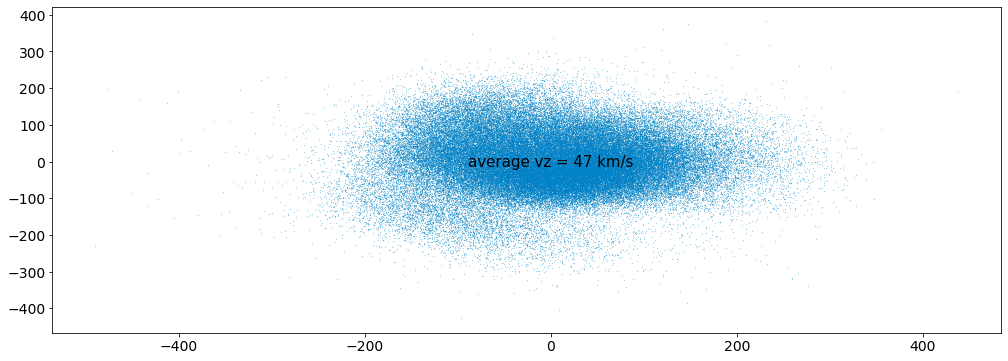

In [129]:
plt.scatter(vx_parts - vxmean, vz_parts - vzmean,  s = 0.6*3446/len(x_parts))
plt.text(0,0, f"average vz = {vzmean:0.0f} km/s", horizontalalignment='center', verticalalignment='center')
plt.show()

In [130]:
#even further downstream

xlims = (shock_position+32,shock_position+34)
ylims = (-10, 10)
zlims = (-10, 10)
print(xlims)

def inregion(pos_part):
    x_part, y_part, z_part = pos_part
    return (    (xlims[0] < x_part < xlims[1]) 
            and (ylims[0] < y_part < ylims[1]) 
            and (zlims[0] < z_part < zlims[1]) )

x_parts = [rposx[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
y_parts = [rposy[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
z_parts = [rposz[i] for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]

vA = 89.371 #Ugly hard code
vx_parts = [velx[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
vy_parts = [vely[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]
vz_parts = [velz[i]*vA for i in range(0, len(rposx))
      if inregion((rposx[i], rposy[i], rposz[i]))]

vxmean = np.mean(vx_parts)
vzmean = np.mean(vz_parts)

(150, 152)


In [131]:
len(x_parts)

117499

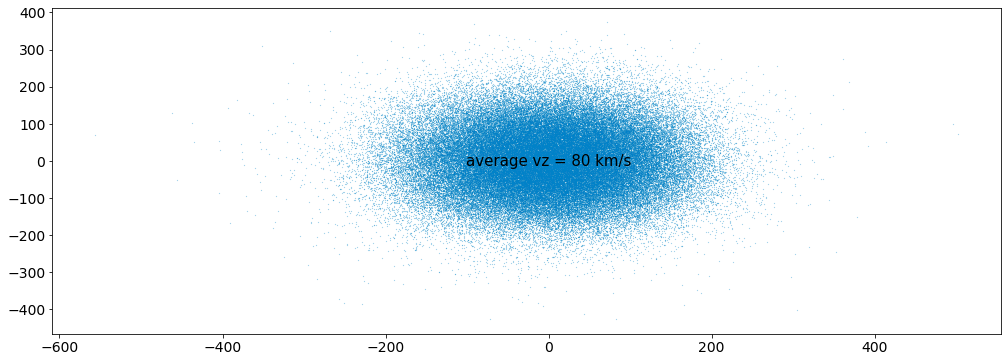

In [132]:
plt.scatter(vx_parts - vxmean, vz_parts - vzmean, s = 0.55*3832/len(x_parts))
plt.text(0,0, f"average vz = {vzmean:0.0f} km/s", horizontalalignment='center', verticalalignment='center')
plt.show()